## Check GPU's availability

In [1]:
## The usual imports
import torch
## print out the pytorch version used
print(f"torch version: {torch.__version__}, GPU support: {torch.cuda.is_available()}")

torch version: 2.6.0+cu124, GPU support: True


## Load Trained Model to Test

In [2]:
import pytorch_lightning as pl
from torchmetrics.classification import ConfusionMatrix
from resnet_classifier import *

exp_root = "../../_exp/"
task_name = exp_root + "ClassAB/"
num_classes = 2

if (True): # testing anamal classification
    task_name = exp_root + "Dataset/"
    num_classes = 3

model_name = task_name + "/models/last.ckpt"
model = ResNetClassifier.load_from_checkpoint(model_name, dataset_root=task_name)
model.eval();

In [3]:
trainer = pl.Trainer(default_root_dir=task_name) # (fast_dev_run=3)
# trainer.predict(model, model.test_dataloader());  # result (preds & gts) are stored in model.output_preds & output_gts
trainer.test(model);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.9916201233863831     │
│      test_loss_epoch      │    0.06070166826248169    │
└───────────────────────────┴───────────────────────────┘

## Confusion Matrix on Testset

The test dataset contains 66 cat images (cls_id = 0), 250 dog images (cls_id = 1) and 42 horse images (cls_id = 2). Classification accuracy is 99.4% (2 error out of 358). Confusion matrix is shown as below:

In [ ]:
# study confusion matrix on testset: 
y_gts   = torch.cat(model.output_gts).detach().cpu()
y_preds = torch.cat(model.output_preds).detach().cpu()

y_hat  = torch.argmax(y_preds, dim=1)
confmat = ConfusionMatrix(task = 'multiclass', num_classes=model.num_classes)
print(confmat(y_hat, y_gts))

tensor([[ 65,   1,   0],
        [  1, 249,   0],
        [  1,   0,  41]])


There are three classification errors (seem all due to wrong label or images with multiple animals): 
- dog --> cat : image labeled as dog but actually has a cat occluding a dog's eye 
- horse --> cat : image wrongly labeled as horse. Model prediction seems more correct.
- cat --> dog : image labeled as cat but actually contains both 1 cat and 1 larger dog


Cases falsely classified as class 0


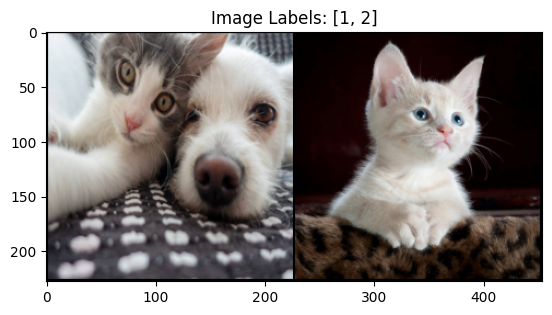

Cases falsely classified as class 1


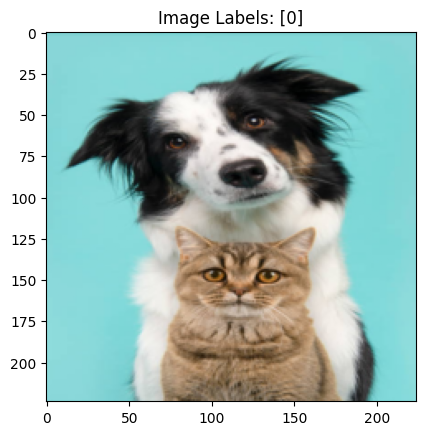

In [5]:
from utils import *

testset = model.test_dataloader().dataset
for cls_id in range(model.num_classes):
    collect_error_cases(y_hat, y_gts, testset, cls_id)